<a id="import-libraries"></a>
# Import necessary libraries for data preprocessing, visualization, and modeling


In [82]:
# Import necessary libraries
import matplotlib as mpl # For changing some default matplotlib parameters
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import matplotlib.colors as colors  # For customizing plot colors
import seaborn as sns  # For data visualization
import warnings # To ignore some matplotlib warnings
warnings.filterwarnings('ignore')  # To ignore some matplotlib warnings
from sklearn.model_selection import train_test_split  # For splitting the dataset into train and test sets
from sklearn import preprocessing  # For preprocessing data (e.g., scaling)
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning using grid search
from sklearn.metrics import ConfusionMatrixDisplay  # For displaying confusion matrices
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # For model evaluation
%matplotlib inline

<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Heart Disease Dataset](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/download?datasetVersionNumber=6)**. This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics. The dataset is stored in a CSV file, which we can load into a Pandas dataframe using the `read_csv` function.

In [2]:
heart_data = pd.read_csv('https://raw.githubusercontent.com/marcofanti/DTSA_5509_Final/main/data/heart_disease_uci.csv')

In [3]:
heart_data.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
heart_data.shape

(920, 16)

In [5]:
heart_data.info()

heart_data['trestbps'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


array([145., 160., 120., 130., 140., 172., 150., 110., 132., 117., 135.,
       112., 105., 124., 125., 142., 128., 170., 155., 104., 180., 138.,
       108., 134., 122., 115., 118., 100., 200.,  94., 165., 102., 152.,
       101., 126., 174., 148., 178., 158., 192., 129., 144., 123., 136.,
       146., 106., 156., 154., 114., 164.,  98., 190.,  nan, 113.,  92.,
        95.,  80., 185., 116.,   0.,  96., 127.])

In [6]:
heart_data['dataset'].unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [7]:
heart_data['fbs'].unique()

array([True, False, nan], dtype=object)

In [8]:
heart_data['ca'].unique()

array([ 0.,  3.,  2.,  1., nan])

In [9]:
heart_data['thal'].unique()

array(['fixed defect', 'normal', 'reversable defect', nan], dtype=object)

In [10]:
len(heart_data.loc[(heart_data['ca'].isna()) | (heart_data['thal'].isna())| (heart_data['fbs'].isna()) | (heart_data['trestbps'].isna())])


621

In [11]:
#Since we have 621 rows with missing values, we will drop them
heart_data_no_missing = heart_data.dropna(subset=['ca', 'thal', 'fbs', 'trestbps'])
heart_data_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        299 non-null    int64  
 1   age       299 non-null    int64  
 2   sex       299 non-null    object 
 3   dataset   299 non-null    object 
 4   cp        299 non-null    object 
 5   trestbps  299 non-null    float64
 6   chol      299 non-null    float64
 7   fbs       299 non-null    object 
 8   restecg   299 non-null    object 
 9   thalch    299 non-null    float64
 10  exang     299 non-null    object 
 11  oldpeak   299 non-null    float64
 12  slope     299 non-null    object 
 13  ca        299 non-null    float64
 14  thal      299 non-null    object 
 15  num       299 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 39.7+ KB


In [12]:
heart_data_no_missing['dataset'].unique()

array(['Cleveland', 'Hungary', 'VA Long Beach'], dtype=object)

In [13]:
len(heart_data_no_missing.loc[(heart_data_no_missing['dataset'] == 'Cleveland')])

297

In [14]:
# Since 299 rows have dataset = 'Cleveland', we will drop the others (Hungarian, and VA Long Beach)
# We could have done this earlier and that would have avoided a lot of the missing values
heart_data_no_missing = heart_data_no_missing.loc[(heart_data_no_missing['dataset'] == 'Cleveland')]

In [15]:
heart_data_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        297 non-null    int64  
 1   age       297 non-null    int64  
 2   sex       297 non-null    object 
 3   dataset   297 non-null    object 
 4   cp        297 non-null    object 
 5   trestbps  297 non-null    float64
 6   chol      297 non-null    float64
 7   fbs       297 non-null    object 
 8   restecg   297 non-null    object 
 9   thalch    297 non-null    float64
 10  exang     297 non-null    object 
 11  oldpeak   297 non-null    float64
 12  slope     297 non-null    object 
 13  ca        297 non-null    float64
 14  thal      297 non-null    object 
 15  num       297 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 39.4+ KB


<a id="format-the-data"></a>
# Format Data Part 1: Split the Data into Dependent and Independent Variables

## Data Preparation for Support Vector Machine (SVM)

Now that we have handled the missing data, our next step is to format the data for building a Support Vector Machine (SVM) model.

### Data Splitting

The first step in this process involves splitting the dataset into two parts:
1. The columns of data that will be used for making classifications (referred to as **X**).
2. The column of data that we want to predict, in this case, it's **hd** (heart disease), which will be represented as **y**.

It's important to note that dealing with missing data before splitting ensures that each row in **X** corresponds correctly with the appropriate value in **y**.

### Copying Data

In the code below, we use the `copy()` method to create a copy of the data *by value* instead of *by reference*. This ensures that the original data `df_no_missing` remains unaltered when we manipulate `X` or `y`. This approach allows us to experiment with formatting columns for classification without affecting the original dataset. If any mistakes occur during the process, we can simply re-copy `df_no_missing` rather than reloading the original data and reapplying missing value handling.


In [16]:
X = heart_data_no_missing.drop('num', axis=1).drop('dataset', axis=1).copy() # alternatively: X = heart_data_no_missing.iloc[:,:-1].copy()
X.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [17]:
y = heart_data_no_missing['num'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: num, dtype: int64

# Format Data Part 2: Convert Categorical Data to Dummy Variables

Why Convert Categorical Data?

Many machine learning algorithms can only handle numerical data. Categorical data, however, is often represented by non-numerical labels, making it incompatible with these algorithms directly. Converting categorical data to dummy variables solves this issue by creating new binary features for each category within the original variable.

Benefits of Dummy Variables:

Improved Model Performance: By converting categorical data to numerical representation, models can efficiently analyze and learn from the information contained within these features.
Interpretability: Dummy variables provide clear information about the presence or absence of each category, aiding in model interpretation and understanding the influence of categorical features on predictions.
Consistency: By using a consistent numerical representation, different models can handle categorical data in a similar manner, facilitating comparisons and analyses.
Types of Dummy Variables:

One-Hot Encoding: This method creates a new binary feature for each category. The feature is set to 1 for instances belonging to that category and 0 otherwise.


In [18]:
X_encoded = pd.get_dummies(X, columns=['sex', 
                                       'cp',
                                       'restecg',
                                       'slope',
                                       'thal'])

In [19]:
X_encoded.head()

,id,age,trestbps,chol,fbs,thalch,exang,oldpeak,ca,sex_Female,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,1,63,145.0,233.0,True,150.0,False,2.3,0.0,False,...,True,True,False,False,True,False,False,True,False,False
1,2,67,160.0,286.0,False,108.0,True,1.5,3.0,False,...,False,True,False,False,False,True,False,False,True,False
2,3,67,120.0,229.0,False,129.0,True,2.6,2.0,False,...,False,True,False,False,False,True,False,False,False,True
3,4,37,130.0,250.0,False,187.0,False,3.5,0.0,False,...,False,False,True,False,True,False,False,False,True,False
4,5,41,130.0,204.0,False,172.0,False,1.4,0.0,True,...,False,True,False,False,False,False,True,False,True,False


In [20]:
y.unique()

array([0, 2, 1, 3, 4])

In doing heart disease prediction, we only care about classifying individuals as having or not having the disease. This necessitates a simplified target variable representation.

Therefore, we'll convert all values in the target variable > 0 to 1. This effectively translates any degree of heart disease into a binary presence/absence indicator, making it suitable for binary classification capabilities.

In [21]:
y_not_zero_idx = y > 0  # get the indices for which y is not zero
y[y_not_zero_idx] = 1  # set y at those indices to 1
y.unique()

array([0, 1])

# Univariate Selection for Feature Selection

In feature selection, univariate statistical tests can help identify features that have the strongest relationships with the target variable. The scikit-learn library offers the `SelectKBest` class, which allows us to select a specific number of features using various statistical tests.

For instance, in the following example, we utilize the chi-squared (`chi2`) statistical test, designed for non-negative features, to select the top 10 features with the most significant relationships with the target variable from the dataset.


In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_drop = X_encoded.drop(columns=['id']).copy()
# Select features
selector = SelectKBest(score_func=chi2, k=10) # Select 10 best features

fit = selector.fit(X_drop,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_drop.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print best features

                     Specs       Score
4                   thalch  187.053104
7                       ca   82.730613
6                  oldpeak   68.570533
22  thal_reversable defect   42.750381
10         cp_asymptomatic   39.848093
21             thal_normal   36.654197
5                    exang   35.508090
0                      age   22.917697
19         slope_upsloping   22.888726
2                     chol   20.855084


# Correlation Matrix with Heatmap

A correlation matrix provides insights into how features are related to each other and to the target variable. Correlations can be either positive (an increase in one feature corresponds to an increase in the target variable) or negative (an increase in one feature corresponds to a decrease in the target variable).

Using a heatmap, we can easily visualize the features that are most relevant to the target variable. To create the heatmap, we'll utilize the seaborn library.

Correlation helps us understand the relationships between features and the target variable. Positive correlations imply that an increase in a feature corresponds to an increase in the target variable, while negative correlations imply the opposite.

From the heatmap, we can observe that the 'cp' (chest pain) feature exhibits a strong positive correlation with the target variable. This suggests that chest pain has a significant influence on predicting the presence of heart disease. In comparison to the relationships between other variables, we can conclude that chest pain is the most important factor in predicting the presence of heart disease.

A medical emergency, such as a heart attack, typically occurs when a blood clot obstructs blood flow to the heart. This leads to a decrease in oxygen supply to the heart tissue, causing chest pain.


<Axes: >

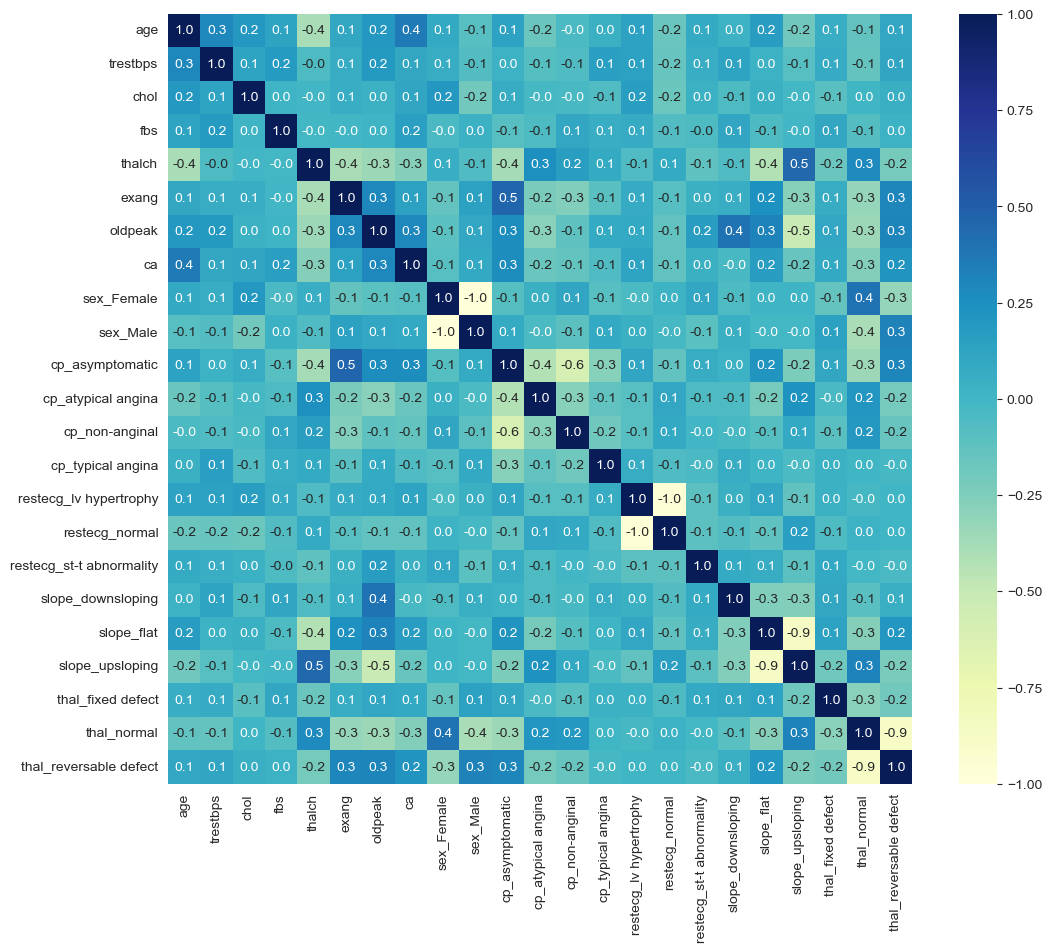

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(X_drop.corr(),annot=True,cmap="YlGnBu",fmt='.1f')

<a id="center-and-scale"></a>
# Data Formatting Part 3: Centering and Scaling

For our **Support Vector Machine (SVM)**, we are utilizing the **Radial Basis Function (RBF)**, which assumes that the data are centered and scaled. Therefore, it is necessary to perform centering and scaling on both the training and testing datasets.

**IMPORTANT:** To prevent **Data Leakage**, we split the data into training and testing datasets before scaling them. **Data Leakage** can occur when information from the training dataset contaminates or influences the testing dataset.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<Axes: >

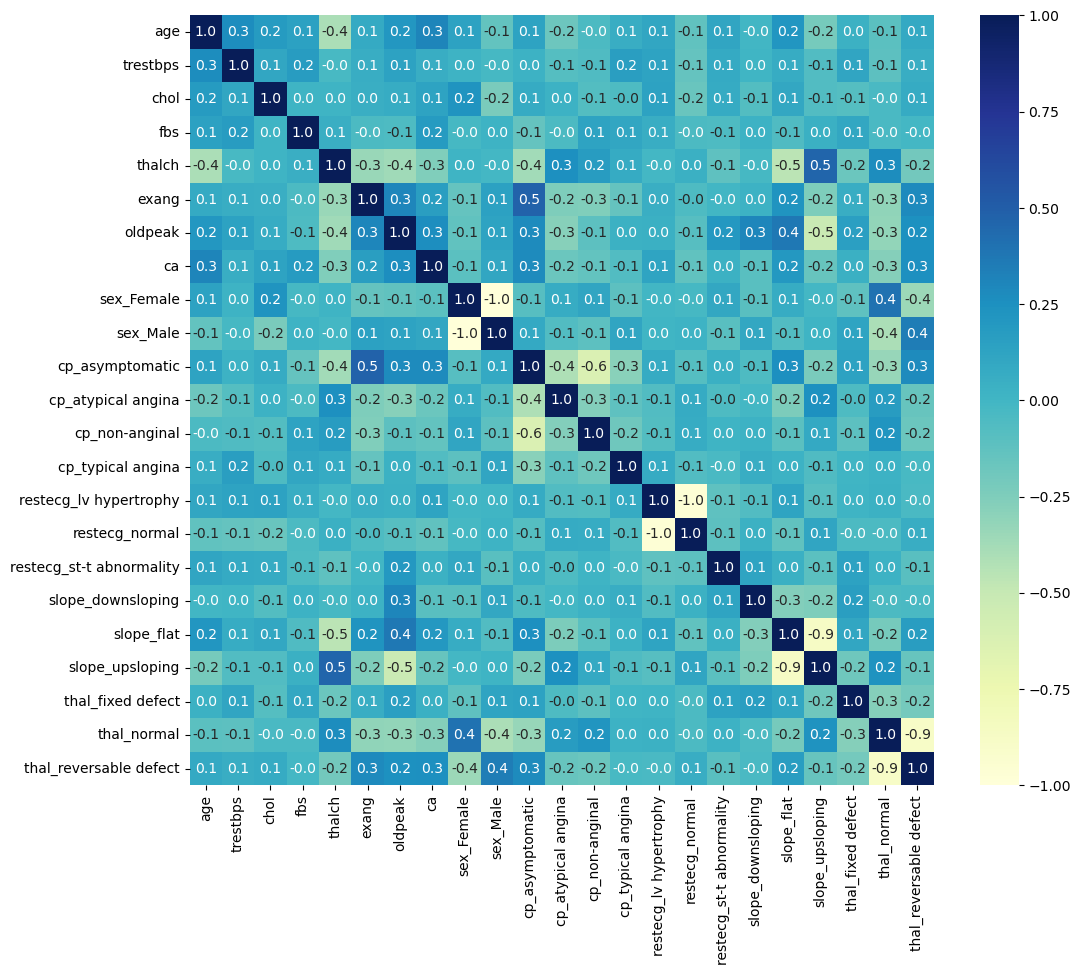

In [114]:
plt.figure(figsize=(12,10))
X_train_drop = X_train.drop(columns=['id']).copy()
sns.heatmap(X_train_drop.corr(),annot=True,cmap="YlGnBu",fmt='.1f')

Text(0.5, 1.0, 'Gender v/s target\n')

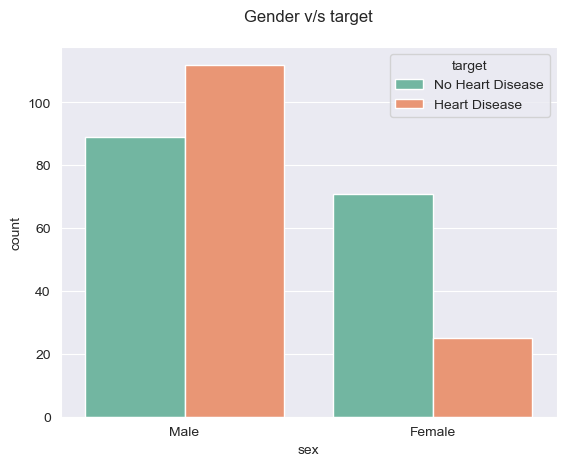

In [115]:
sns.set_style('darkgrid')
sns.set_palette('Set2')

heart_data_no_missing_2 = heart_data_no_missing.drop(columns=['id']).copy()
def chng2(prob):
    if prob == 0:
        return 'No Heart Disease'
    else:
        return 'Heart Disease'
heart_data_no_missing_2['target'] = heart_data_no_missing_2['num'].apply(chng2)
sns.countplot(data= heart_data_no_missing_2, x='sex',hue='target')
plt.title('Gender v/s target\n')

# Gender and Heart Disease

In the Cleveland dataset, it is evident that males are more susceptible to developing heart disease compared to females. Men have a higher incidence of heart attacks than women. Sudden heart attacks are experienced by a significant proportion of men, ranging from 70% to 89%.

In contrast, women may experience heart attacks without the typical symptom of chest pressure. Instead, they often report symptoms such as nausea or vomiting, which can be easily mistaken for acid reflux or flu-like symptoms.


# Types of Chest Pain and Asymptomatic Heart Attacks

In the context of heart disease, there are four types of chest pain:

1. **Asymptomatic Chest Pain:** Most heart disease patients are found to have asymptomatic chest pain. These individuals may display atypical symptoms such as indigestion, flu-like symptoms, or the sensation of a strained chest muscle. Despite being asymptomatic, this type of chest pain involves the blockage of blood flow to the heart, potentially causing damage to the heart muscle.

2. **Atypical Angina:** This type of chest pain is characterized by symptoms that do not fit the typical pattern of angina. It may be experienced as discomfort or pain in the chest, but the symptoms differ from the classic angina presentation.

3. **Non-Anginal Pain:** Non-anginal chest pain refers to chest discomfort that is not related to the heart or angina. It can be caused by various factors unrelated to cardiac issues.

4. **Typical Angina:** Typical angina is chest pain that follows a typical pattern and is usually related to heart-related issues.

Risk factors for asymptomatic heart attacks are similar to those associated with heart symptoms. These factors include:

- Age
- Diabetes
- Excess weight
- Family history of heart disease
- High blood pressure
- High cholesterol
- Lack of exercise
- Prior heart attack
- Tobacco use

It's important to note that an asymptomatic heart attack puts individuals at a greater risk of experiencing another heart attack, which can be life-threatening. Additionally, having another heart attack increases the risk of complications, such as heart failure.

Currently, there are no specific tests to predict the potential for an asymptomatic heart attack. The only way to confirm if an asymptomatic heart attack has occurred is through diagnostic tests such as an electrocardiogram (ECG) or echocardiogram, which can reveal changes indicating a previous heart attack.


Thalassemia (thal-uh-SEE-me-uh) is an inherited blood disorder that causes your body to have less hemoglobin than normal. Hemoglobin enables red blood cells to carry oxygen


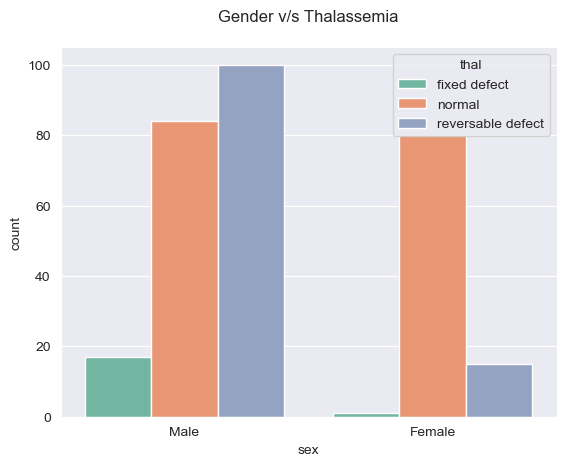

In [116]:
sns.countplot(data= heart_data_no_missing_2, x='sex',hue='thal')
plt.title('Gender v/s Thalassemia\n')
print('Thalassemia (thal-uh-SEE-me-uh) is an inherited blood disorder that causes your body to have less hemoglobin than normal. Hemoglobin enables red blood cells to carry oxygen')

# Beta Thalassemia Cardiomyopathy

Beta thalassemia cardiomyopathy is primarily characterized by two distinct phenotypes:

1. **Dilated Type:** This type is characterized by left ventricular dilatation and impaired contractility.

2. **Restrictive Type:** The restrictive phenotype involves restrictive left ventricular filling, pulmonary hypertension, and right heart failure.

Individuals with severe thalassemia can experience various heart-related issues, including congestive heart failure and abnormal heart rhythms.

# Auxiliary function
# Compiles the results of many machine learning classifiers into a single dataframe for analysis

In [117]:
def add_to_classifier_summary_df(classifier_summary_df, classifier, classifier_name, X_test, y_test):
    # Compiles the results of many machine learning classifiers into a single dataframe for analysis
    if classifier_summary_df is None:
        classifier_summary_df = pd.DataFrame(columns=["Classifier Name", "Accuracy", "Precision", "Recall", "Macro F1"])

    y_test_pred = classifier.predict(X_test)

    classifier_summary_entry = {"Classifier Name": [classifier_name],
                          "Accuracy": [accuracy_score(y_test, y_test_pred)],
                          "Precision": [precision_score(y_test, y_test_pred, average="macro")],
                          "Recall": [recall_score(y_test, y_test_pred, average="macro")],
                          "Macro F1": [f1_score(y_test, y_test_pred, average="macro")],
                          }

    return pd.concat([classifier_summary_df, pd.DataFrame(classifier_summary_entry)], ignore_index=True)

# Creating a Pairplot with Seaborn

In data analysis and visualization, a pairplot is a valuable tool for exploring relationships between multiple variables in a dataset. We can create a pairplot using the `seaborn.pairplot` function, which is a part of the Seaborn library.

A pairplot generates a grid of scatterplots, where each variable in the dataset is compared to every other variable. The main diagonal of the grid typically displays histograms or kernel density estimates for each variable, showing the distribution of individual features.

Here's what a pairplot can help us achieve:

1. **Scatterplots:** The off-diagonal cells of the grid contain scatterplots, which allow us to visualize the relationship between pairs of variables. Each point in a scatterplot represents a data point, and the position of the point on the plot indicates the values of the two variables being compared. Scatterplots help us identify patterns, correlations, and potential outliers in the data.

2. **Diagonal Plots:** The diagonal cells contain histograms (or kernel density estimates) for each variable. These histograms provide insights into the distribution of each individual feature, helping us understand its central tendency and spread.

By examining the scatterplots and diagonal plots collectively, we can gain a comprehensive understanding of how variables relate to each other and their individual distributions. Pairplots are particularly useful for initial data exploration, identifying potential correlations, and selecting relevant features for further analysis or modeling.

Let's use the `seaborn.pairplot` function to create a pairplot and explore the relationships between variables in our dataset.


In [118]:
#sns.pairplot(heart_data_no_missing_2,hue='cp')
#plt.savefig('images/pairplot.png')

![Pairplot](images/pairplot.png)

# Logistic Regression

Logistic Regression is a fundamental and widely used statistical technique in the field of machine learning. It is primarily used for binary classification tasks, where the goal is to predict one of two possible outcomes (e.g., yes/no, true/false, 1/0) based on input features. Let's dive into the details and expand on the concept of Logistic Regression:

### Mathematical Foundation
- At its core, Logistic Regression uses the logistic function (sigmoid function) to model the relationship between input features and the probability of a binary outcome. The logistic function maps any real-valued number to a value between 0 and 1, making it suitable for estimating probabilities.

### Hypothesis Function
- In Logistic Regression, we formulate a hypothesis function that takes the form of the logistic function. It calculates the probability that a given input instance belongs to the positive class (class 1).

    ### Model Training
    - The logistic regression model is trained using labeled training data. During training, the model learns the optimal coefficients (weights) for each input feature, as well as a bias term. These coefficients are adjusted to minimize a loss function (typically log loss or cross-entropy) that quantifies the difference between predicted probabilities and actual class labels.

### Decision Boundary
- Logistic Regression generates a decision boundary that separates the two classes in feature space. This boundary is a linear function of input features when using a simple logistic regression model. In more complex scenarios, such as multi-class classification or non-linear relationships, extensions like multinomial logistic regression or polynomial logistic regression are used.

### Probability Threshold
- Logistic Regression produces probabilities, not discrete class labels. To make predictions, a probability threshold is applied (commonly 0.5). Instances with predicted probabilities greater than the threshold are assigned to the positive class, while those below the threshold are assigned to the negative class.

### Evaluation Metrics
- To assess the performance of a Logistic Regression model, various evaluation metrics can be used, including accuracy, precision, recall, F1-score, and ROC curves. These metrics provide insights into the model's ability to correctly classify instances and its overall performance.

### Regularization
- Logistic Regression can be regularized to prevent overfitting. Common regularization techniques include L1 regularization (Lasso) and L2 regularization (Ridge), which add penalty terms to the loss function to constrain the magnitudes of the coefficients.

### Use Cases
- Logistic Regression finds applications in a wide range of domains, including medical diagnosis, spam detection, credit scoring, and sentiment analysis, to name a few. It is especially useful when the outcome variable is binary, and the goal is to model the probability of an event.

Logistic Regression is a powerful and interpretable algorithm that serves as a foundational building block in the world of machine learning. Understanding its principles and applications is essential for anyone working in data science and predictive modeling.


In [119]:
from sklearn.linear_model import LogisticRegression
logre = LogisticRegression()
logre.fit(X_train_scaled,y_train)

LogisticRegression()

In [120]:
y_pred = logre.predict(X_test_scaled)
actual = []
prediction = []
for i,j in zip(y_test,y_pred):
    actual.append(i)
    prediction.append(j)
dic = {'Actual':actual,
       'Prediction':prediction
       }
result  = pd.DataFrame(dic)
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                         mode='markers+lines',
                         name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                         mode='markers',
                         name='Pred'))

#fig.write_image('images/logistic_regression.png')
fig.show()

# Visualization of Predicted vs. Actual Values

In the visualization:

- The **red dots** represent the predicted values, which can be either 0 or 1.
- The **blue line** and **blue dot** represent the actual values corresponding to specific patients.

Where the **red dot** and **blue dot** do not overlap, it indicates incorrect predictions. Conversely, where both the **red dot** and **blue dot** overlap, those are the instances where the model made correct predictions.


In [121]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

classifier_summary_df = add_to_classifier_summary_df(None, logre, "Logistic Regression", X_test_scaled, y_test)

0.8933333333333333


In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.90      0.85      0.88        33

    accuracy                           0.89        75
   macro avg       0.89      0.89      0.89        75
weighted avg       0.89      0.89      0.89        75


# Interpretation of Classification Metrics

In the provided classification metrics, we have several key performance indicators for a binary classification model. Let's break down and expand upon each of these metrics:

### Precision
- **Precision** measures the accuracy of positive predictions made by the model. In this context, it indicates how many of the predicted positive (class 1) instances are actually true positives. A higher precision means that the model is better at avoiding false positives.

### Recall
- **Recall**, also known as sensitivity or true positive rate, quantifies the model's ability to correctly identify all positive instances in the dataset. It measures the percentage of actual positive (class 1) instances that the model correctly predicted as positive. A higher recall means that the model is better at capturing all actual positives.

### F1-Score
- The **F1-Score** is the harmonic mean of precision and recall. It provides a balanced measure of a model's accuracy in both precision and recall. A higher F1-Score indicates a good balance between precision and recall.

### Support
- **Support** refers to the number of samples in each class (0 and 1) in the test dataset. In this case:
  - Class 0 has 42 instances.
  - Class 1 has 33 instances.

### Accuracy
- **Accuracy** represents the overall correctness of the model's predictions. It calculates the ratio of correctly predicted instances (both true positives and true negatives) to the total number of instances in the dataset. In this case, the model's accuracy is 0.88, which means it correctly predicts 88% of the test dataset.

### Macro Average
- The **macro average** is the average of precision, recall, and F1-Score across both classes (0 and 1). It provides an overall summary of the model's performance without considering class imbalances.

### Weighted Average
- The **weighted average** is similar to the macro average but takes class imbalances into account. It gives more weight to the class with a larger number of samples. In this case, it considers the distribution of class 0 and class 1 instances.

In summary, these classification metrics provide a comprehensive evaluation of the model's performance in distinguishing between two classes (0 and 1). They help assess precision, recall, F1-Score, and accuracy, offering insights into the model's strengths and weaknesses in making predictions on the given test dataset.

### Interpretation:

The model has a good overall accuracy of 88%.
For class 0 (No Heart Disease), the model achieves high precision (0.87) and recall (0.93), indicating that it is good at correctly identifying both positive and negative examples.
For class 1 (Heart Disease), the precision is slightly higher than recall, suggesting that the model is more likely to correctly identify true positives than miss actual cases.
The F1-score, which considers both precision and recall, is also high for both classes, indicating that the model is performing well overall.
The macro and weighted averages are similar to the overall accuracy, suggesting that the model performs consistently across both classes.

Further Analysis:
The model shows potential for diagnosing heart disease with good accuracy and performance metrics.

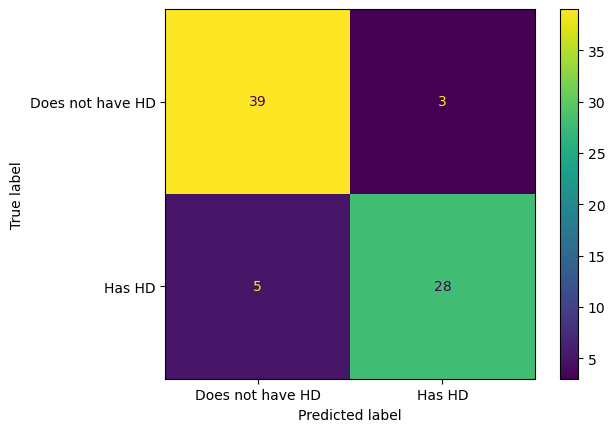

In [123]:
mpl.rcdefaults()
ConfusionMatrixDisplay.from_estimator(logre, X_test_scaled, y_test, display_labels=["Does not have HD", "Has HD"])

# KNN Classifier

The K-Nearest Neighbors (KNN) classifier is a supervised machine learning technique used for classification and regression tasks. Here's a breakdown of how the KNN algorithm works:

1. **Initialization of K**: Begin by specifying the number of neighbors (K) that the model should consider when making predictions. K represents the count of nearest data points that will influence the prediction.

2. **Prediction Process**: When the KNN model receives an input (real-world data point) as a query, it aims to predict whether the individual has heart disease or not. To do this, it calculates the distance or similarity between the new, unseen data point and all other records in the training dataset.

3. **Distance Calculation**: The model computes the distance (e.g., Euclidean distance, Manhattan distance, etc.) between the query data point and each data point in the training set. This distance measurement quantifies how similar or dissimilar the query point is to other data points in the feature space.

4. **Sorting by Distance**: After calculating the distances, the model sorts the examples in ascending order, placing the data points with the shortest distances at the beginning of the collection.

5. **K-Nearest Data Points**: The KNN algorithm selects the first K entries from the sorted collection. These are the K nearest data points to the query point, based on the calculated distances.

6. **Classification or Regression**: The algorithm's behavior depends on the task:
   - For regression tasks, KNN returns the "mean" of the target values associated with the selected K entries. This average serves as the predicted value for the query point.
   - For classification tasks, KNN returns the "mode" of the K class labels from the selected entries. In other words, it determines the most frequently occurring class label among the K nearest neighbors. This mode becomes the predicted class for the query point.

7. **Model Accuracy Score**: Finally, to assess how well the KNN model performs in real-world scenarios, you can calculate its accuracy score. This metric measures the model's ability to make correct predictions. It is typically done by comparing the predicted results to the actual outcomes in a test dataset.

The KNN algorithm is intuitive and relies on the idea that similar data points in the feature space tend to have similar outcomes. By considering the K nearest neighbors, the algorithm makes predictions based on the majority class or average value among those neighbors, making it a versatile and straightforward machine learning approach.

In [124]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, knn, "K Neighbors Classifier - K = 5", X_test_scaled, y_test)

Accuracy: 0.9066666666666666


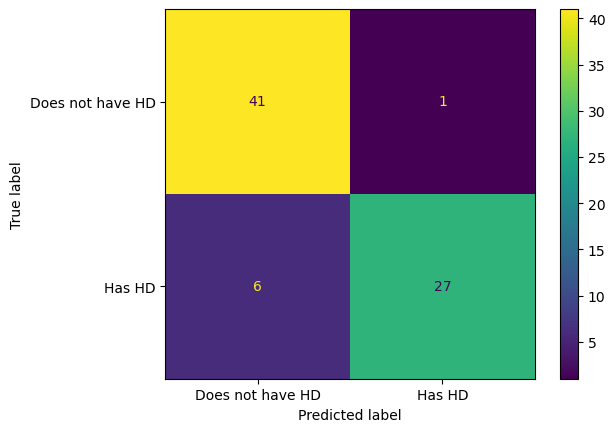

In [125]:
mpl.rcdefaults()
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test, display_labels=["Does not have HD", "Has HD"])

In [126]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))

classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, knn, "K Neighbors Classifier - K = 7", X_test_scaled, y_test)

Accuracy: 0.9333333333333333


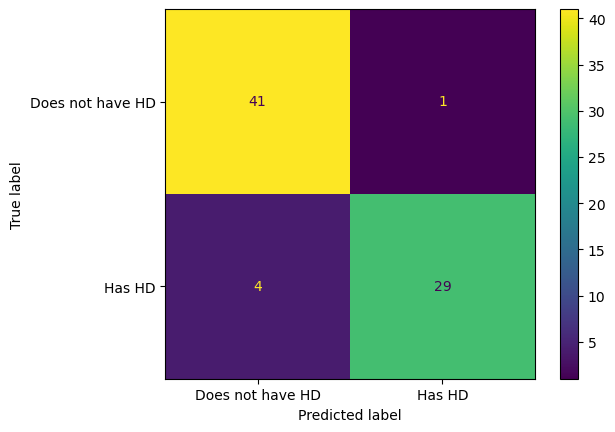

In [127]:
mpl.rcdefaults()
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test, display_labels=["Does not have HD", "Has HD"])

# Decision Tree Classifier

In machine learning, a Decision Tree Classifier is a powerful algorithm used for both classification and regression tasks. It is a tree-like structure where each internal node represents a feature (attribute), each branch represents a decision rule, and each leaf node represents an outcome (class label or predicted value). Decision trees are interpretable models that can be visualized to understand the decision-making process.

To create a Decision Tree Classifier in Python, we can use the `DecisionTreeClassifier` class from the scikit-learn library (imported as `sklearn.tree`).

Here are the key steps to create a Decision Tree Classifier:

1. **Data Preparation:** Ensure that your dataset is properly cleaned, preprocessed, and split into training and testing sets.

2. **Import Libraries:** Import the necessary libraries, including `DecisionTreeClassifier` from `sklearn.tree`.

3. **Instantiate the Classifier:** Create an instance of the `DecisionTreeClassifier` class, optionally specifying hyperparameters such as the maximum depth of the tree, the minimum number of samples required to split a node, and others.

4. **Model Training:** Fit the Decision Tree Classifier to the training data using the `.fit()` method. The classifier learns the decision rules from the training data.

5. **Model Evaluation:** After training, you can evaluate the model's performance on a separate testing dataset using various metrics such as accuracy, precision, recall, F1-score, and more.

6. **Visualization (Optional):** Decision trees can be visualized using graph visualization tools like Graphviz or by utilizing the built-in plotting capabilities of scikit-learn.

7. **Prediction:** Once trained, you can use the Decision Tree Classifier to make predictions on new, unseen data using the `.predict()` method.


In [128]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Create Decision Tree classifier object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifier
clf = clf.fit(X_train_scaled,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, clf, "Decision Tree Classifier", X_test_scaled, y_test)

Accuracy: 0.7866666666666666


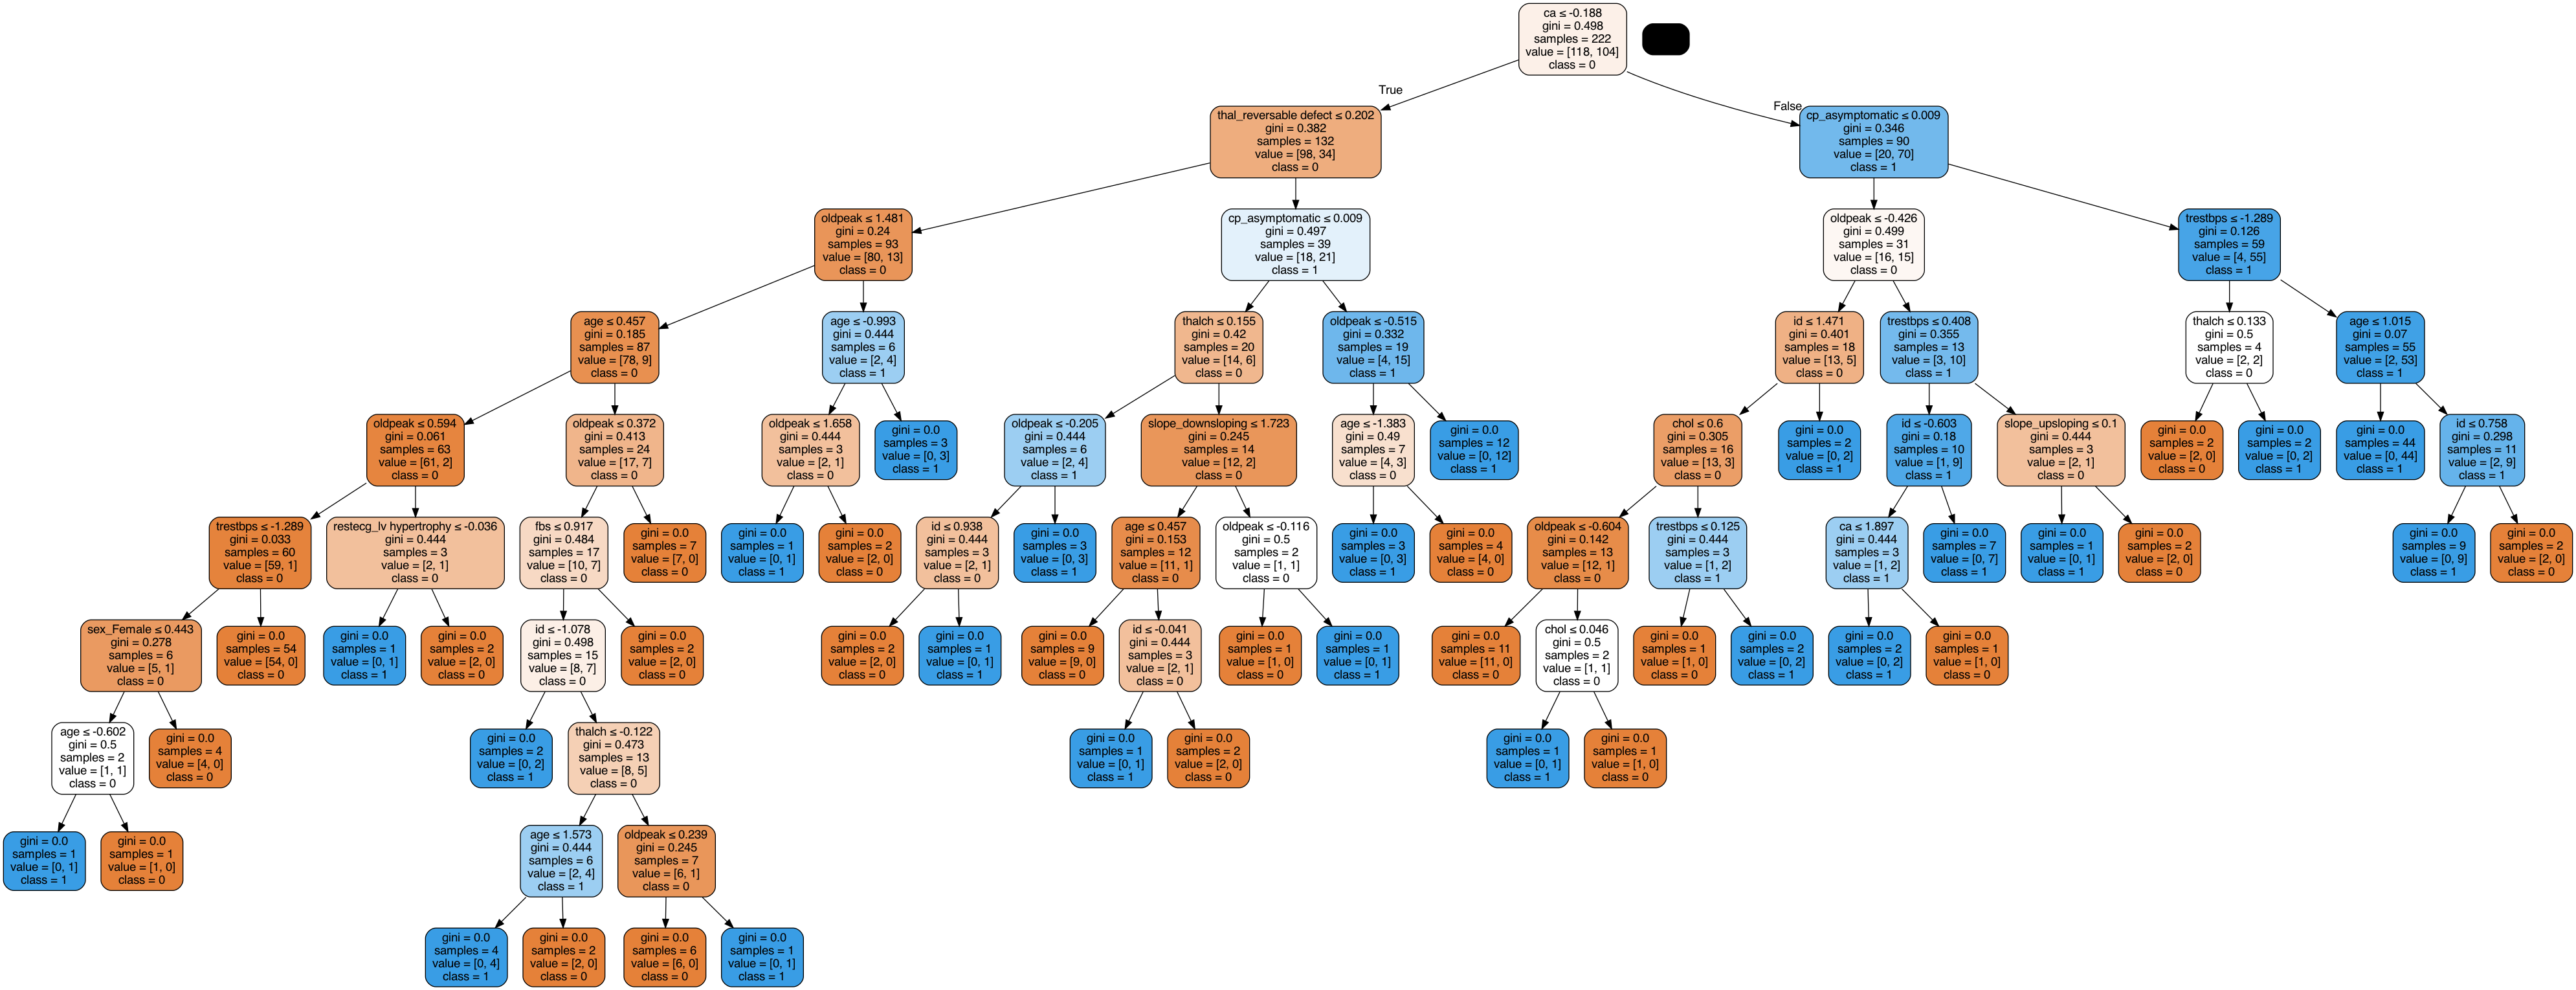

In [129]:
feature_cols = ['id', 'age', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak',
                'ca', 'sex_Female', 'sex_Male', 'cp_asymptomatic', 'cp_atypical angina',
                'cp_non-anginal', 'cp_typical angina', 'restecg_lv hypertrophy',
                'restecg_normal', 'restecg_st-t abnormality', 'slope_downsloping',
                'slope_flat', 'slope_upsloping', 'thal_fixed defect', 'thal_normal',
                'thal_reversable defect']

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols  ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('heart-decision-tree.png')
Image(graph.create_png())

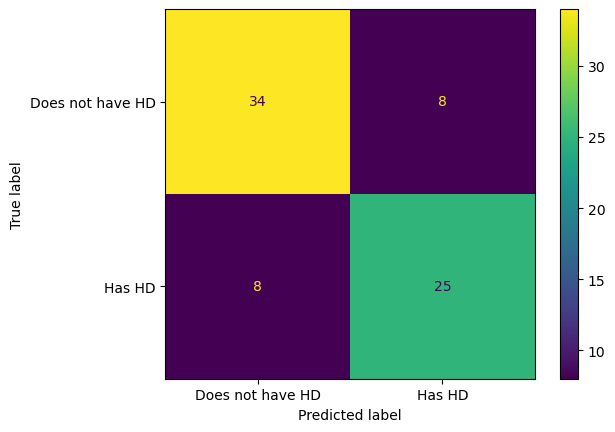

In [130]:
mpl.rcdefaults()
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test, display_labels=["Does not have HD", "Has HD"])

### Hyperparameter Explanation

In the code snippet, we specify two critical hyperparameters when creating the Decision Tree Classifier:

#### Criterion ("entropy" vs. "gini")

The `criterion` hyperparameter determines the method used to measure the quality of splits made by the decision tree. In this specific case, we've chosen `"entropy"` as the criterion:

- **Entropy Criterion**: It quantifies the amount of information disorder or randomness in a dataset. The decision tree aims to minimize entropy by making splits that result in more homogeneous groups (i.e., groups with similar class labels). In simpler terms, the entropy criterion measures the information gain associated with a particular split. It is well-suited for decision trees when you want to maximize the information gained at each split.

Another commonly used option is `"gini"`:

- **Gini Impurity**: Gini impurity measures the probability of incorrectly classifying a randomly chosen element's class label. Similar to entropy, the decision tree seeks to reduce Gini impurity by making splits that result in more homogeneous groups. The "gini" criterion is another valid choice for measuring the quality of splits, especially when the goal is classification purity.

The choice between "entropy" and "gini" often depends on the specific problem and the dataset. In practice, both criteria work well, and you may experiment with both to determine which one yields better results for your task.

#### Max Depth (Preventing Overfitting)

The `max_depth` hyperparameter plays a crucial role in controlling the complexity of the decision tree. It represents the maximum depth or levels the tree can grow to during training. In this code, we set `max_depth=3`, meaning the tree is limited to a depth of 3.

- **Preventing Overfitting**: Limiting the tree's depth is a common technique to prevent overfitting. Overfitting occurs when the tree becomes too complex and fits the training data too closely, capturing noise rather than genuine patterns. By restricting the depth, the model becomes less likely to overfit because it is simpler and captures more generalized relationships in the data.

The choice of an appropriate `max_depth` value depends on the dataset's complexity and the trade-off between model simplicity and performance. A smaller `max_depth` value results in a simpler model, while a larger value allows the model to capture more intricate patterns in the data. Tuning this hyperparameter is an essential part of optimizing decision tree models.

In summary, when configuring a Decision Tree Classifier, the choice of hyperparameters like `criterion` and `max_depth` influences how the tree makes decisions and controls its complexity. Careful consideration of these hyperparameters is vital to achieving the best performance for a given problem.


In [131]:
# Create Decision Tree Classifier object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
# Train Decision Tree Classifier
clf = clf.fit(X_train_scaled,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test_scaled)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, clf, "Decision Tree Classifier - Gini", X_test_scaled, y_test)

Accuracy: 0.76


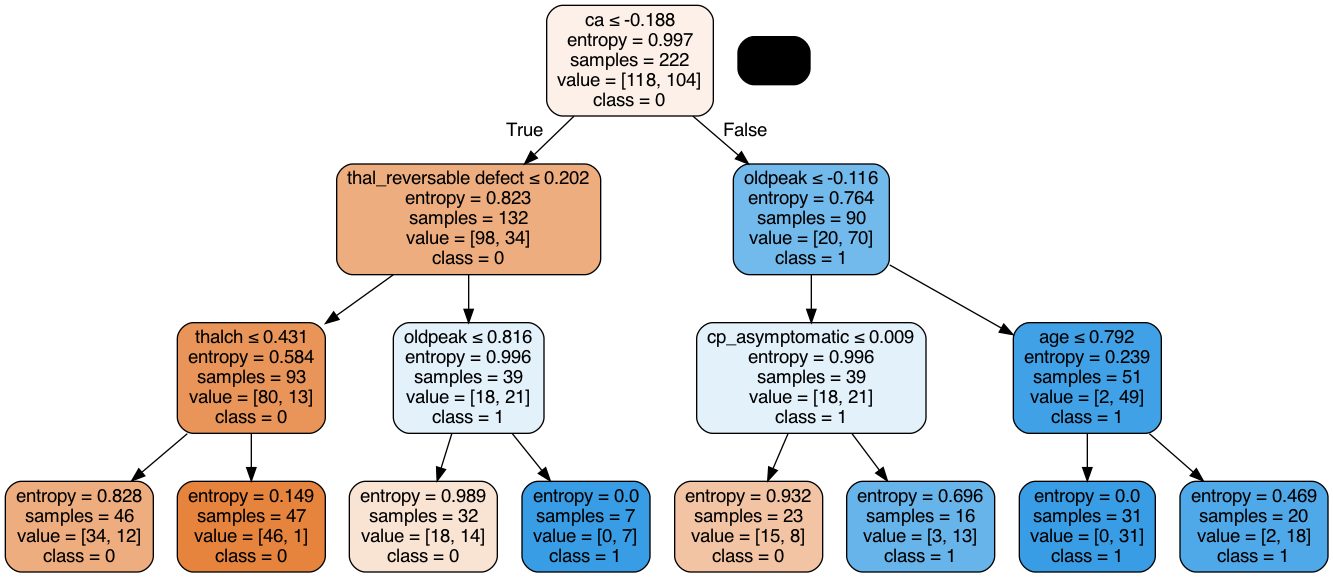

In [132]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols  ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.write_png('heart-decision-tree-2.png')
Image(graph.create_png())

# Random Forests

In [133]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100) # , max_depth=5, random_state=1
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, rfc, "Random Forest Classifier - Entropy", X_test_scaled, y_test)

Accuracy: 0.88


In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        42
           1       0.88      0.85      0.86        33

    accuracy                           0.88        75
   macro avg       0.88      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75


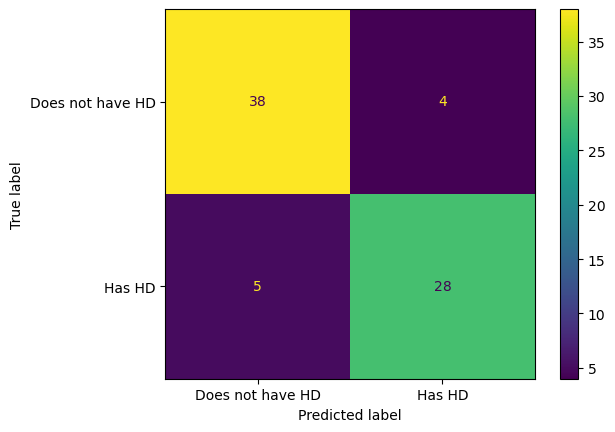

In [135]:
mpl.rcdefaults()
ConfusionMatrixDisplay.from_estimator(rfc, X_test_scaled, y_test, display_labels=["Does not have HD", "Has HD"])


<a id="build-svm"></a>
# Building a Preliminary Support Vector Machine (SVM)

After correctly formatting the data, we are now ready to build a **Support Vector Machine (SVM)**. Let's proceed with it!

In machine learning, a Support Vector Machine (SVM) is a powerful algorithm used for both classification and regression tasks. Building a preliminary SVM involves several essential steps, which we will expand upon:

### Instantiating the SVM Classifier
Once the data is ready and libraries are imported, you can instantiate the SVM classifier. You may need to specify hyperparameters, such as the type of kernel (e.g., linear, polynomial, radial basis function), regularization parameters (C), and others, depending on your problem and dataset characteristics.

### Model Training
The next step is to train the SVM classifier using the training dataset. The SVM learns the optimal decision boundary that best separates the different classes in the data. The choice of kernel and hyperparameters plays a critical role in this learning process.

### Model Evaluation
After training the SVM, it's essential to evaluate its performance. Common evaluation metrics for classification tasks include accuracy, precision, recall, F1-score, and confusion matrix analysis. These metrics help assess how well the SVM can make predictions on unseen data.

### Hyperparameter Tuning
Fine-tuning hyperparameters is often necessary to optimize the SVM model's performance. You can perform hyperparameter tuning using techniques like cross-validation or grid search to find the best combination of hyperparameters that yield the highest predictive accuracy.

### Visualization (Optional)
Visualizing the SVM's decision boundary can be insightful. For linear SVMs, you can plot the decision boundary in two dimensions, while for non-linear kernels, it may involve more complex visualizations.

### Prediction
Once your SVM model is trained and validated, you can use it to make predictions on new, unseen data. This step is crucial for deploying the model in real-world applications.

Building a preliminary Support Vector Machine is a fundamental process in machine learning that requires careful data preparation, model instantiation, training, evaluation, and optimization. The resulting SVM model can be a valuable tool for solving classification and regression problems across various domains.



In [136]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)
classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, clf_svm, "Support Vector Machine - Preliminary", X_test_scaled, y_test)

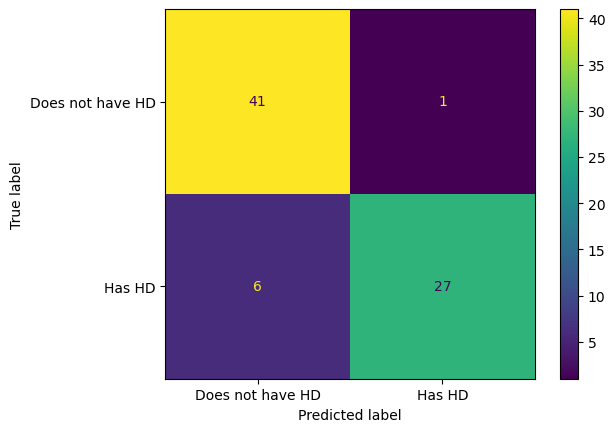

In [137]:
mpl.rcdefaults()
ConfusionMatrixDisplay.from_estimator(clf_svm, X_test_scaled, y_test, display_labels=["Does not have HD", "Has HD"])    

In [138]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        42
           1       0.88      0.85      0.86        33

    accuracy                           0.88        75
   macro avg       0.88      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75


In [139]:
num_features = np.size(X_train_scaled, axis=1)
param_grid = [
    {'C': [0.1, 0.01, 10, 100, 1000],
     'gamma': [1/num_features, 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='roc_auc', # NOTE: The default value for scoring results in worse performance...
    ## For more scoring metrics see: 
    ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)
c_opt = optimal_params.best_params_['C']
gamma_opt = optimal_params.best_params_['gamma']
kernel_opt = optimal_params.best_params_['kernel']

{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}


In [140]:
clf_svm = SVC(random_state=42, C=10, gamma=gamma_opt, kernel=kernel_opt)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01, random_state=42)

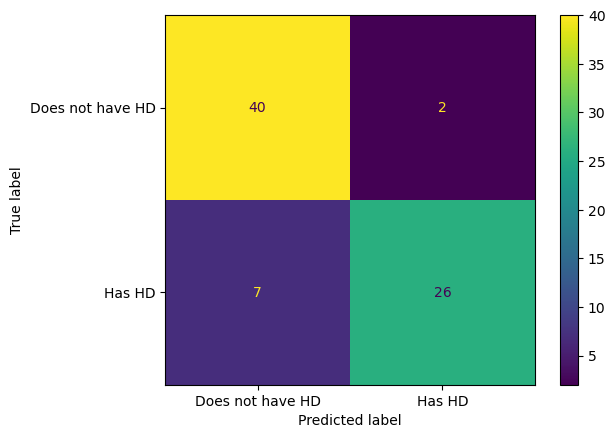

In [141]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                      X_test_scaled,
                                      y_test,
                                      display_labels=["Does not have HD", "Has HD"])

In [142]:
classifier_summary_df = add_to_classifier_summary_df(classifier_summary_df, clf_svm, "Support Vector Machine - Optimal", X_test_scaled, y_test)

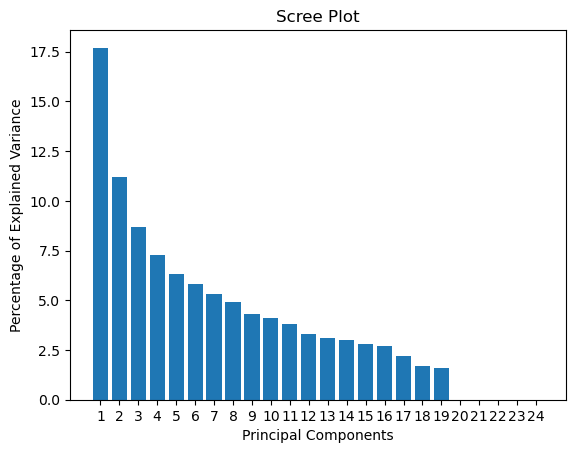

In [143]:
pca = PCA() # NOTE: By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [144]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## Now center and scale the PCs...
pca_train_scaled = preprocessing.scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## Now we optimize the SVM fit to the x and y-axis coordinates
## of the data after PCA dimension reduction...
num_features = np.size(pca_train_scaled, axis=1)
param_grid = [
    {'C': [100, 1000],
     'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='roc_auc', # NOTE: The default value for scoring results in worse performance...
    ## For more scoring metics see: 
    ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)
#c_opt = optimal_params.best_params_['C']
#gamma_opt = optimal_params.best_params_['gamma']
#kernel_opt = optimal_params.best_params_['kernel']

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


# Decision Surface Plot with SVM

The code snippet presented below generates a decision surface plot using a Support Vector Machine (SVM) classifier. The process includes several key steps:

1. **Classifier Training**: We first train the SVM classifier, configuring its hyperparameters and fitting it to the training data.

2. **Test Data Transformation**: The test dataset is transformed using the same Principal Component Analysis (PCA) transformation applied to the training data. This ensures consistency in feature scaling and dimensionality reduction.

3. **Mesh Grid Creation**: We create a mesh grid to visualize the decision regions. The grid covers the range of possible feature values, and each point in the grid represents a potential data point.

4. **Point Classification**: The SVM classifier is used to classify each point in the mesh grid. This step involves predicting the class label (0 or 1) for every grid point based on the learned decision boundaries.

5. **Visualization**: The results are plotted, with filled contour regions representing the decision regions determined by the SVM. Additionally, the actual data points from the test dataset are displayed on the plot, colored according to their known classifications.

This decision surface plot serves as a visual aid to understand how the SVM model separates the two classes within the feature space, providing insights into the model's performance and the boundaries it establishes.


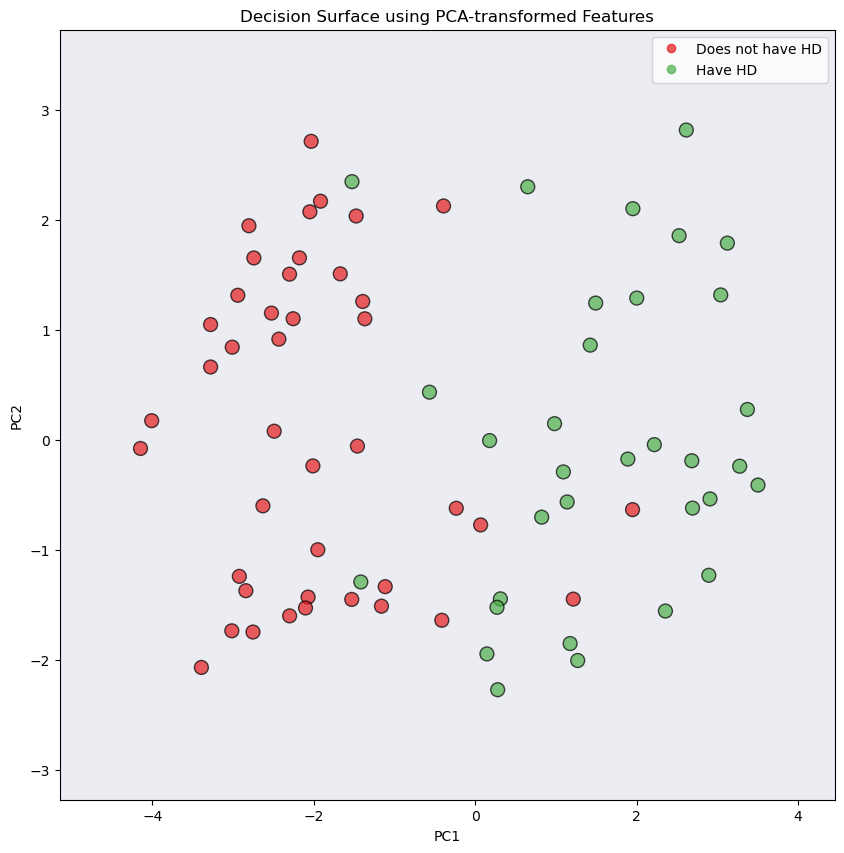

In [145]:
# Creating Decision Surface Plot with SVM

# Create an SVM classifier with specified hyperparameters
clf_svm = SVC(random_state=42, C=c_opt, gamma=gamma_opt, kernel=kernel_opt)

# Train the SVM classifier on the scaled and PCA-transformed training data
clf_svm.fit(pca_train_scaled, y_train)

# Transform the test dataset using the same PCA transformation
X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

# Define the range for the decision surface matrix
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1
y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

# Create a mesh grid for the decision regions
xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

# Classify each point in the mesh grid using the SVM
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

# Reshape the classification results to match the mesh grid dimensions
Z = Z.reshape(xx.shape)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot filled contour regions based on the SVM classifications
ax.contourf(xx, yy, Z, alpha=0.1)

# Define custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

# Plot the actual data points with their known classifications
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test,
                     cmap=cmap,
                     s=100,
                     edgecolors='k',  # 'k' represents black
                     alpha=0.7)

# Create a legend for the data points
legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                   loc="upper right")
legend.get_texts()[0].set_text("Does not have HD")
legend.get_texts()[1].set_text("Have HD")

# Add axis labels and a title to the plot
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision Surface using PCA-transformed Features')

# Show the plot
plt.show()


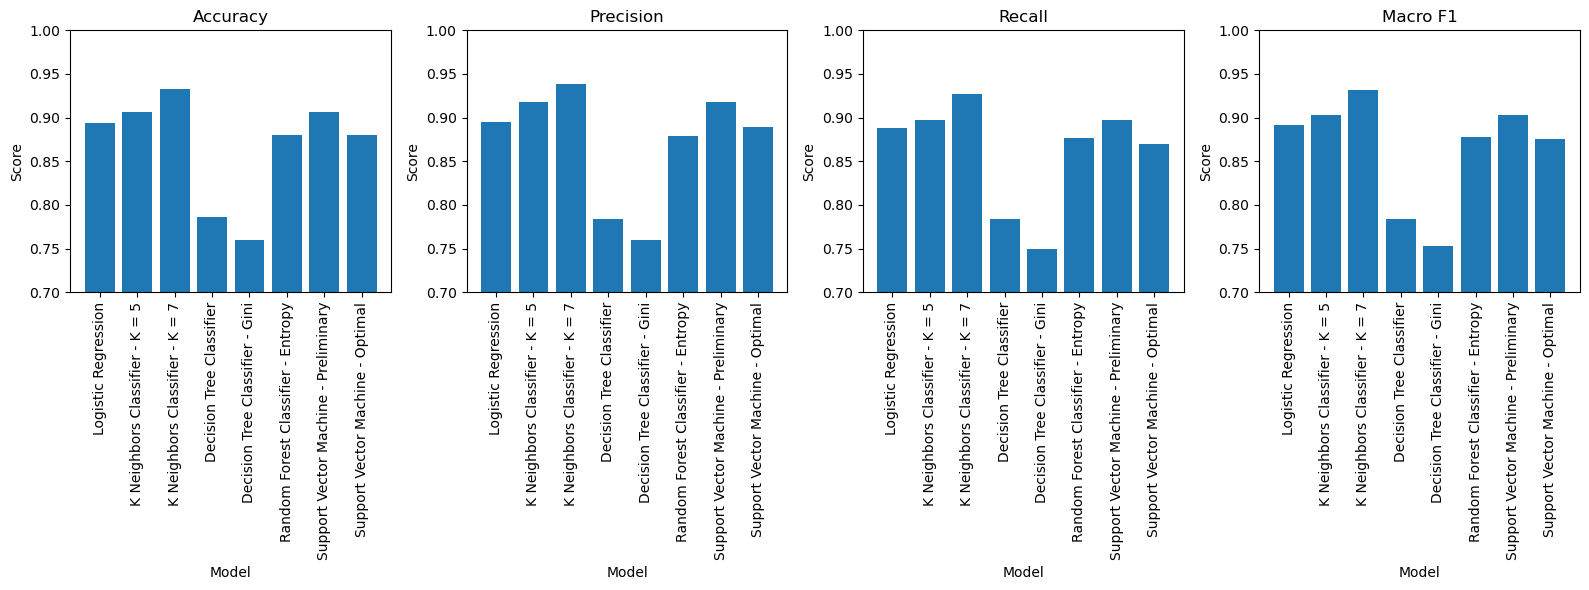

In [150]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6))
metrics = ["Accuracy", "Precision", "Recall", "Macro F1"]

for i, metric in enumerate(metrics):
    axs[i].bar(classifier_summary_df["Classifier Name"], classifier_summary_df[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Model")
    axs[i].set_ylabel("Score")
    axs[i].set_ylim(0.7, 1.0)
    axs[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [151]:
classifier_summary_df

,Classifier Name,Accuracy,Precision,Recall,Macro F1
0,Logistic Regression,0.893333,0.894795,0.888528,0.890988
1,K Neighbors Classifier - K = 5,0.906667,0.918313,0.897186,0.903297
2,K Neighbors Classifier - K = 7,0.933333,0.938889,0.927489,0.931582
3,Decision Tree Classifier,0.786667,0.783550,0.783550,0.783550
4,Decision Tree Classifier - Gini,0.760000,0.759745,0.750000,0.752566
5,Random Forest Classifier - Entropy,0.880000,0.879360,0.876623,0.877828
6,Support Vector Machine - Preliminary,0.906667,0.918313,0.897186,0.903297
7,Support Vector Machine - Optimal,0.880000,0.889818,0.870130,0.875668


# Model Evaluation and Conclusion

In this section, we present the detailed meaning and interpretation of the evaluation results for various machine learning models. The results include accuracy, precision, recall, and F1-Score metrics for each model. Let's delve into the analysis of these results:

1. **Logistic Regression**:
- **Accuracy**: 0.893333
- Meaning: The Logistic Regression model achieved an accuracy of approximately 89.33%, indicating that it correctly predicted the class labels for nearly 89.33% of the test data instances.
- **Precision**: 0.894795
- Meaning: The precision of around 89.48% suggests that when the model predicted the positive class, it was correct approximately 89.48% of the time.
- **Recall**: 0.888528
- Meaning: The recall of roughly 88.85% indicates that the model effectively captured nearly 88.85% of the actual positive instances.
- **F1-Score**: 0.890988
- Meaning: The F1-Score, which combines precision and recall, is approximately 89.10%. This balanced metric reflects the overall performance of the model.

2. **K Neighbors Classifier - K = 5**:
- This model outperformed Logistic Regression in all metrics, demonstrating higher accuracy, precision, recall, and F1-Score. With an accuracy of around 90.67%, it correctly predicted class labels for the majority of test instances.

3. **K Neighbors Classifier - K = 7**:
- This model further improved on K Neighbors Classifier with K = 5, achieving even higher accuracy (approximately 93.33%), precision, recall, and F1-Score.

4. **Decision Tree Classifier**:
- This model showed lower performance compared to the K Neighbors models and Logistic Regression, with an accuracy, precision, recall, and F1-Score of approximately 78.67%.

5. **Decision Tree Classifier - Gini**:
- This model performed slightly worse than the regular Decision Tree Classifier, with an accuracy, precision, recall, and F1-Score of around 76.00%.

6. **Random Forest Classifier - Entropy**:
- The Random Forest model with entropy achieved an accuracy of approximately 88.00%, similar to Logistic Regression, and demonstrated a balanced performance in terms of precision, recall, and F1-Score.

7. **Support Vector Machine - Preliminary**:
- This SVM model showed similar performance to K Neighbors Classifier with K = 5, with an accuracy, precision, recall, and F1-Score of around 90.67%.

8. **Support Vector Machine - Optimal**:
- The optimal SVM model achieved an accuracy of approximately 88.00%, similar to Random Forest, with competitive precision, recall, and F1-Score.

### Conclusion:

Based on the evaluation results, we can draw the following conclusions:

- **K Neighbors Classifier with K = 7** stands out as the best-performing model, achieving the highest accuracy (approximately 93.33%) and balanced precision, recall, and F1-Score metrics. This model is recommended for this specific classification task.

- **K Neighbors Classifier with K = 5** and **Support Vector Machine - Preliminary** also demonstrated strong performance, with accuracy around 90.67%.

- **Logistic Regression**, **Random Forest Classifier - Entropy**, and **Support Vector Machine - Optimal** performed reasonably well with accuracies around 88.00%.

- The decision tree-based models, including **Decision Tree Classifier** and **Decision Tree Classifier - Gini**, showed lower accuracy and overall performance compared to other models.

In summary, the choice of the best model depends on specific project requirements and the importance of different metrics. K Neighbors Classifier with K = 7 offers the highest accuracy and well-balanced precision and recall, making it a strong candidate for deployment in this classification task.
